# 多项式回归 模拟欠拟合 和 过拟合

In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.4258],
         [-0.2770]]),
 tensor([[ 1.0000e+00, -1.4258e+00,  1.0165e+00, -4.8311e-01,  1.7221e-01,
          -4.9107e-02,  1.1670e-02, -2.3770e-03,  4.2364e-04, -6.7116e-05,
           9.5695e-06, -1.2404e-06,  1.4738e-07, -1.6165e-08,  1.6463e-09,
          -1.5649e-10,  1.3945e-11, -1.1696e-12,  9.2647e-14, -6.9526e-15],
         [ 1.0000e+00, -2.7704e-01,  3.8375e-02, -3.5438e-03,  2.4544e-04,
          -1.3599e-05,  6.2793e-07, -2.4852e-08,  8.6061e-10, -2.6491e-11,
           7.3391e-13, -1.8484e-14,  4.2673e-16, -9.0939e-18,  1.7995e-19,
          -3.3236e-21,  5.7548e-23, -9.3783e-25,  1.4434e-26, -2.1047e-28]]),
 tensor([-2.9080,  4.7426]))

In [ ]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0190697  1.2002991 -3.412861   5.586519 ]]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

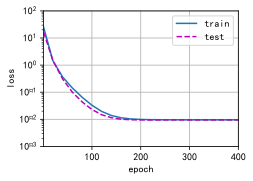

In [28]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

# 2、权重衰减

权重衰减（通常称为L2正则化），可能是最广泛使用的对参数化机器学习模型进行正则化的技术

In [7]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [9]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义L2范数惩罚

In [10]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

定义训练代码实现

In [11]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

忽略正则化直接训练

w的L2范数是： 12.885335922241211


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

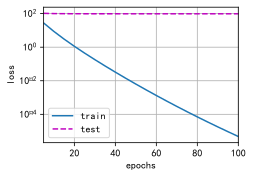

In [12]:
train(lambd=0)

使用权重衰减

w的L2范数是： 0.37815362215042114


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


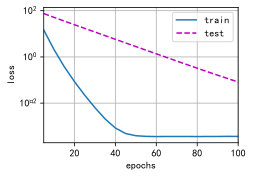

In [14]:
train(lambd=3)

## 简洁实现

In [15]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这些图看起来和我们从零开始实现权重衰减时的图相同

w的L2范数： 13.121548652648926


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

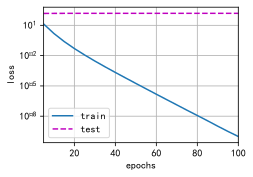

In [16]:
train_concise(0)

w的L2范数： 0.438818097114563


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

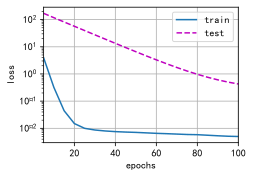

In [17]:
train_concise(3)